In [22]:
from steam_review_scraper import get_game_review 
import timeit

start_time = timeit.default_timer()

reviews = get_game_review(1599600, language='english')

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")

In [ ]:
def filter_df(df):
    df = df[['playtime', 'post_date', 'helpfulness', 'review', 'recommend','early_access_review']]
    return df

In [43]:
sorted_reviews = reviews.sort_values(by='helpfulness', ascending=False)
print(sorted_reviews['helpfulness'].head(10))

1      712
10     678
0      470
118    426
2      418
3      355
6      326
12     240
9      238
5      237
Name: helpfulness, dtype: int64


In [27]:
print(reviews.keys())

Index(['user', 'playtime', 'user_url', 'post_date', 'helpfulness', 'review',
       'recommend', 'early_access_review'],
      dtype='object')


In [37]:
print(reviews.loc[reviews['early_access_review'].notnull(), 'early_access_review'])

Series([], Name: early_access_review, dtype: object)


In [23]:
print(reviews)

                  user  playtime  \
0            antiviris     890.1   
1              ZSeraph      31.8   
2          Blue August      19.3   
3              Shintox     184.8   
4          Tol Eressea      26.3   
...                ...       ...   
8864  Fluffy Crypt TTV      81.7   
8865           Yeoutie      12.0   
8866              Xahk      51.1   
8867      ShadowHex101       7.4   
8868          Josty125      75.3   

                                               user_url         post_date  \
0                  https://steamcommunity.com/id/ibull/   August 28, 2022   
1                https://steamcommunity.com/id/ZSeraph/    August 8, 2022   
2     https://steamcommunity.com/profiles/7656119811...    August 8, 2022   
3                https://steamcommunity.com/id/Shintox/    August 8, 2022   
4             https://steamcommunity.com/id/toleressea/  January 21, 2023   
...                                                 ...               ...   
8864         https://steamco

In [46]:
print(reviews.iloc[1]['review'])

i forgot to give someone a single piece of broccoli with their plain burger and my whole restaurant got shut down


In [25]:
# print(reviews['playtime'].describe())
reviews['playtime'].describe()

count    8869.000000
mean       64.167820
std       103.290961
min         0.100000
25%        14.900000
50%        33.700000
75%        76.400000
max      2713.200000
Name: playtime, dtype: float64

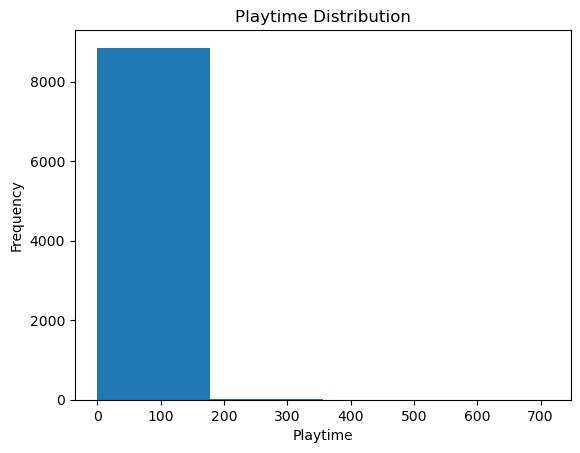

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# create sample data
# data = {'playtime': [2.5, 1.2, 3.8, 4.1, 2.0, 2.8, 3.2, 2.3, 3.5, 1.9]}

# create pandas DataFrame
# reviews = pd.DataFrame(data)

# generate histogram

plt.hist(reviews['helpfulness'], bins=4)
plt.title('Playtime Distribution')
plt.xlabel('Playtime')
plt.ylabel('Frequency')
plt.show()

C:\Users\tbont\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


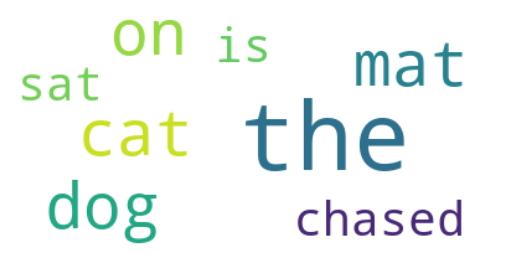

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create sample sentences
sentences = ["The cat sat on the mat", "The dog chased the cat", "The dog is on the mat"]

# create CountVectorizer object to perform bag of words
vectorizer = CountVectorizer()

# fit and transform the sentences into a matrix of token counts
X = vectorizer.fit_transform(sentences)

# create dictionary of token counts
word_counts = dict(zip(vectorizer.get_feature_names(), X.toarray().sum(axis=0)))

# create WordCloud object with the word counts
wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_counts)

# display the WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [52]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='c_v')
similarity_matrix = coherence_model.pairwise_similarity()

# cluster the topics based on their similarity
hierarchical_model = gensim.models.hierarchical.HierarchicalClustering(
    similarity_matrix, distance_threshold=0.5
)
topic_nodes = hierarchical_model.get_clusters()

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# analyze the sentiment of the documents associated with each node
sia = SentimentIntensityAnalyzer()
for node in topic_nodes:
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if node in [t[0] for t in topic_docs[i]]]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    print(f"Node {node}: {topics[node]}, Sentiment: {sentiment}")

ValueError: ("'texts' should be provided for %s coherence.", 'c_v')

In [54]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = gensim.models.hierarchical.HierarchicalClustering(
    similarity_matrix, distance_threshold=0.5
)
topic_nodes = hierarchical_model.get_clusters()

# compute the coherence score for the model
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, coherence='c_v', texts=df['processed_review'])
coherence_score = coherence_model.get_coherence()

# analyze the sentiment of the documents associated with each node
sia = SentimentIntensityAnalyzer()
for node in topic_nodes:
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if node in [t[0] for t in topic_docs[i]]]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    print(f"Node {node}: {topics[node]}, Sentiment: {sentiment}")


AttributeError: module 'gensim.models' has no attribute 'hierarchical'

In [56]:
import nltk
nltk.download('vader_lexicon')
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import AgglomerativeClustering

import timeit

start_time = timeit.default_timer()

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.5, linkage='average', affinity='cosine'
)
hierarchical_model.fit(similarity_matrix)
topic_nodes = hierarchical_model.labels_

# compute the coherence score for the model
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, coherence='c_v', texts=df['processed_review'])
coherence_score = coherence_model.get_coherence()

# analyze the sentiment of the documents associated with each node
sia = SentimentIntensityAnalyzer()
for node in set(topic_nodes):
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_nodes[i] == node]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    print(f"Node {node}: {topics[node]}, Sentiment: {sentiment}")

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...


Node 0: (0, '0.070*"slap" + 0.045*"like" + 0.037*"overcooked" + 0.026*"game" + 0.015*"friends" + 0.014*"cooking" + 0.012*"cook" + 0.011*"stress" + 0.011*"fun" + 0.010*"amazing"'), Sentiment: positive
Node 1: (1, '0.114*"game" + 0.042*"love" + 0.036*"great" + 0.019*"play" + 0.016*"fun" + 0.015*"best" + 0.014*"amazing" + 0.014*"played" + 0.013*"op" + 0.010*"friends"'), Sentiment: positive
Node 2: (2, '0.034*"game" + 0.015*"addicting" + 0.009*"smooth" + 0.008*"great" + 0.008*"win" + 0.008*"play" + 0.007*"friends" + 0.007*"kiss" + 0.007*"overcooked" + 0.006*"fun"'), Sentiment: positive
Node 3: (3, '0.042*"game" + 0.039*"fun" + 0.028*"overcooked" + 0.023*"like" + 0.013*"restaurant" + 0.011*"friends" + 0.010*"cooking" + 0.010*"yes" + 0.009*"time" + 0.009*"recommend"'), Sentiment: positive
Node 4: (4, '0.035*"game" + 0.029*"like" + 0.018*"restaurant" + 0.012*"plate" + 0.009*"time" + 0.008*"overcooked" + 0.007*"playing" + 0.007*"kitchen" + 0.006*"run" + 0.006*"day"'), Sentiment: positive
Node 

In [58]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
import matplotlib.pyplot as plt

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.5, linkage='average', affinity='cosine'
)
topic_nodes = hierarchical_model.get_clusters()

# create a graph of the topics and their connections
graph = nx.Graph()
for node in topic_nodes:
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if node in [t[0] for t in topic_docs[i]]]
    sentiment_scores = [SentimentIntensityAnalyzer().polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    label = f"Node {node}\nSentiment: {sentiment}"
    graph.add_node(node, label=label)
    for i, j in zip(*np.triu_indices(len(node_docs), k=1)):
        graph.add_edge(node_docs[i][0], node_docs[j][0])

# visualize the graph
pos = nx.spring_layout(graph)
labels = {node: graph.nodes[node]['label'] for node in graph.nodes()}
nx.draw(graph, pos, with_labels=False)
nx.draw_networkx_labels(graph, pos, labels, font_size=8, font_family="sans-serif")
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'get_clusters'

In [59]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.5, linkage='average', affinity='cosine'
)
hierarchical_model.fit(similarity_matrix)
topic_nodes = hierarchical_model.labels_

# create the graph and add nodes
graph = nx.Graph()
for node in set(topic_nodes):
    graph.add_node(node, topics=topics[node], sentiment=None)

# analyze the sentiment of the documents associated with each node and add edges
sia = SentimentIntensityAnalyzer()
for node in set(topic_nodes):
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_nodes[i] == node]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    graph.nodes[node]['sentiment'] = sentiment
    for other_node in set(topic_nodes):
        if node == other_node:
            continue
        other_node_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_nodes[i] == other_node]
        if set(node_docs) & set(other_node_docs):
            graph.add_edge(node, other_node)

# draw the graph
pos = nx.spring_layout(graph, k=0.25, iterations=100)
nx.draw(graph, pos=pos, with_labels=True, font_size=8, font_weight='bold', node_size=200, node_color=topic_nodes, cmap='tab10')
nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8, edge_labels={edge: len(set(topic_docs[i]) & set(topic_docs[j])) for edge, (i, j) in graph.edges})
plt.show()

TypeError: unhashable type: 'list'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\tbont\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tbont\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


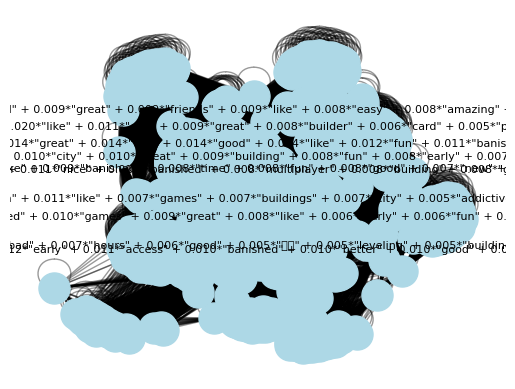

Node 0: (0, '0.047*"game" + 0.022*"like" + 0.012*"banished" + 0.010*"city" + 0.010*"great" + 0.009*"building" + 0.008*"fun" + 0.008*"early" + 0.007*"multiplayer" + 0.007*"games"'), Sentiment: positive
Node 1: (1, '0.061*"game" + 0.011*"play" + 0.011*"like" + 0.009*"banished" + 0.008*"time" + 0.008*"fun" + 0.008*"good" + 0.007*"new" + 0.007*"early" + 0.007*"things"'), Sentiment: positive
Node 2: (2, '0.030*"good" + 0.024*"game" + 0.011*"fun" + 0.011*"like" + 0.007*"games" + 0.007*"buildings" + 0.007*"city" + 0.005*"addictive" + 0.005*"building" + 0.005*"banished"'), Sentiment: positive
Node 3: (3, '0.033*"game" + 0.024*"like" + 0.012*"early" + 0.011*"access" + 0.010*"banished" + 0.010*"better" + 0.010*"good" + 0.008*"fun" + 0.008*"games" + 0.006*"ai"'), Sentiment: positive
Node 4: (4, '0.015*"game" + 0.008*"like" + 0.007*"bad" + 0.007*"hours" + 0.006*"good" + 0.005*"แต" + 0.005*"leveling" + 0.005*"building" + 0.005*"tight" + 0.005*"save"'), Sentiment: positive
Node 5: (5, '0.025*"game" 

In [61]:
import nltk
# nltk.download('vader_lexicon')
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt

import timeit

start_time = timeit.default_timer()

reviews = get_game_review(1307890, language='english')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.5, linkage='average', affinity='cosine'
)
hierarchical_model.fit(similarity_matrix)
topic_nodes = hierarchical_model.labels_

# create a network graph
G = nx.Graph()

# add nodes to the graph
for i, topic in enumerate(topics):
    G.add_node(i, label=topic)

# add edges to the graph
for i, row in enumerate(similarity_matrix):
    for j, sim in enumerate(row):
        if sim > 0.5:
            G.add_edge(i, j)

# plot the network graph
pos = nx.spring_layout(G, k=0.2)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.axis('off')
plt.show()

# analyze the sentiment of the documents associated with each node
sia = SentimentIntensityAnalyzer()
for node in set(topic_nodes):
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_nodes[i] == node]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    print(f"Node {node}: {topics[node]}, Sentiment: {sentiment}")

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")


In [62]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import AgglomerativeClustering

# read data from CSV file
# df = pd.read_csv('data.csv')
df = reviews

# preprocess the text data
def preprocess_text(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_review'] = df['review'].apply(preprocess_text)

# create a dictionary and document-term matrix
dictionary = Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# compute the similarity matrix
similarity_matrix = MatrixSimilarity(lda_model[corpus])

# get the main topics and their associated documents
topics = lda_model.print_topics(num_topics=10, num_words=10)
topic_docs = [lda_model.get_document_topics(corpus[i]) for i in range(len(corpus))]

# cluster the topics based on their similarity
hierarchical_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,
    affinity='precomputed',
    linkage='average'
)
hierarchical_model.fit(similarity_matrix)
topic_nodes = hierarchical_model.labels_

# compute the coherence score for the model
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, coherence='c_v', texts=df['processed_review'])
coherence_score = coherence_model.get_coherence()

# analyze the sentiment of the documents associated with each node
sia = SentimentIntensityAnalyzer()
for node in set(topic_nodes):
    node_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_nodes[i] == node]
    sentiment_scores = [sia.polarity_scores(df['review'][i])['compound'] for i in range(len(df)) if topic_docs[i] in node_docs]
    sentiment = 'positive' if sum(sentiment_scores) > 0 else 'negative'
    print(f"Node {node}: {topics[node]}, Sentiment: {sentiment}")

Node 0: (0, '0.018*"game" + 0.010*"city" + 0.007*"like" + 0.006*"good" + 0.006*"fun" + 0.006*"lot" + 0.005*"add" + 0.005*"banished" + 0.005*"new" + 0.005*"buildings"'), Sentiment: positive
